## Init and Run GMM

In [1]:
%%javascript
Jupyter.utils.load_extensions('tdb_ext/main')

<IPython.core.display.Javascript object>

In [2]:
#this sets the backend to jupyter/ipython that (i think) displays
#     images directly. anyway, it prevents the matplotlib framework
#     python error that is my least favorite thing eeeevvvveeeer.
%matplotlib notebook

import sys
sys.path.append("..")

import gmix_model as gmix
import numpy as np
import tdb as tdb
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gmix_sample_mixture as smpl

import os
os.chdir('/Users/azane/GitRepo/spider')

In [3]:
#read in training and test data
s_x, s_t = gmix.get_xt_from_npz('data/spi_gmix_train.npz', True)
t_x, t_t = gmix.get_xt_from_npz('data/spi_gmix_test.npz', True)

#TEMP
#expand target dimension so variance can be happy.
scaleOut = 100
s_t *= scaleOut
t_t *= scaleOut

### Note on Scaling and Variance Saturation:

   ```GaussianMixtureModel``` needs to handle the variance scaling. The question is, should it scale up from tanh and *then* calculate loss? Or should it keep everything within the tanh range, and then scale up only for outputs?
   
   If the actual range is large, then it would be more accurate and safer to scale up to the range. But, like in the spider example, if the range is small, so it would actually be safer to keep it at tanh. I think if it can be determined that the tanh range can accurately represent the means and variances, then it's best to keep it there. Otherwise, we might need to expand everything to a middle-man range where loss can be calculated, and then expand to the actual range on formula retrieval.

In [4]:
#create gmm with data
np.random.seed(np.random.randint(100000))
gmm = gmix.GaussianMixtureModel(s_x, s_t, t_x, t_t,
                               numGaussianComponents=5, hiddenLayerSize=20,
                               learningRate=0.004) #0.005 worked for 2d

### Thoughts on Hyperparameters

  * The larger the hidden layers, the more representations of globally best solutions. Thus, a slower training rate can be afforded, as there are more routes out of local minima.
  * Small hidden layers may require a larger training rate so it can jump out of local minima.
  * Examining the mixing coefficient averages reveals whether or not some gaussian components are not being used. These should be minimized.
 
### Hyperparameters as Variables

   * We need an **intelligent learning rate**. It should make guesses as to whether it's stuck in a local minima, or honing in on a good solution. If it thinks it's stuck, set the learning rate high to jump out, if it's working on a good solution, keep the learning rate low to stay on track.
      * the loss function needs to scale with the number of samples, otherwise we'll see steeper gradients for for larger sample batches.
   * The **number of gaussian components** can be selected based on how many are being used, and how much. Having this change during training would require a restructuring of the network, however, and preserving training before restructuring may be impossible.
      * in other words, this may slow down training considerably, but complexity reduction would vastly increase execution.
   * It may be worth spawning **a number of networks** working on the same solution. This is a good way to determine whether a **local or global** solution has been found.

# Train Step

In [5]:
%%capture
#d will be a dictionary of evaluated tensors under their standard name.
runTimes = 1000
reports = 20
assert reports>=1

gmm.train(iterations=runTimes, testBatchSize=1000,
          trainBatchSize=5000, reportEvery=int(runTimes/reports))


## Debugging

In [6]:
def scale(x, y, low, high, i=-1):
    """takes two 2d arrays, but only checks the last y column."""
    indices = np.where((y[:,i] >= low) & (y[:,i] <= high))
    return x[indices], y[indices]

In [7]:
def init4d(x, y, yLow=None, yHigh=None):
    """Takes two 2d arrays, but only graphs the 
        first three x's, and the last y."""
    
    #TODO enable this to take two sets of x and y, 
    #    so they can be compared easily.
    
    assert y.ndim == 2
    assert y.shape[1] == 1
    assert x.ndim == 2
    
    if (yLow is not None) and (yHigh is not None):
        #TODO allow the output to be culled by only one.
        #exclude points outside of low/high range
        x, y = scale(x, y, yLow, yHigh)
    
    x = np.squeeze(x.transpose())
    y = np.squeeze(y[:,0])
    
    assert y.ndim == 1
    assert x.ndim == 2
    assert x.shape[0] == 3
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d') #create subplot in figure.
    
    #set the color map to the output dimension.
    scatPlot = ax.scatter(x[0], x[1], x[2], c=y) #create plot
    
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("x3")
    
    #add colorbar label
    cb = fig.colorbar(scatPlot)
    cb.set_label("y")
    
    return fig, scatPlot

<IPython.core.display.Javascript object>


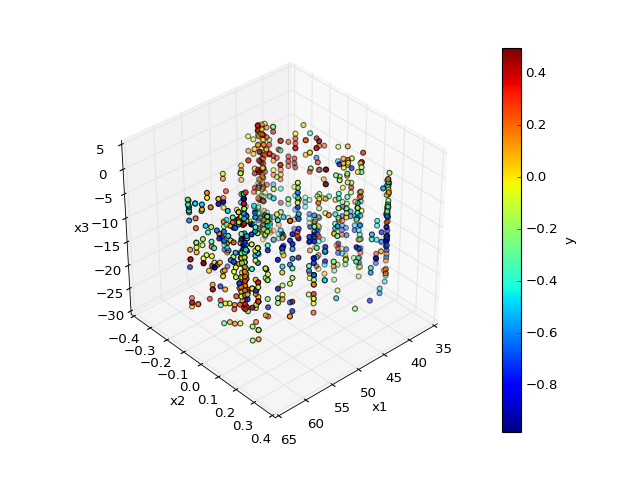

(<matplotlib.figure.Figure at 0x14f716790>,
 <mpl_toolkits.mplot3d.art3d.Path3DCollection at 0x14f73a4d0>)

In [8]:
m, v, u = gmm.get_xmvu()
x, y = smpl.sample_mixture(t_x, m, v, u) #set to gmm sample
#x = t_x; y = t_t #set to actual values

#cull data to a set number of points.
lim = 1000
if x.shape[0] > lim:
    randRows = np.random.randint(x.shape[0],size=lim)
    x = x[randRows]
    y = y[randRows]

init4d(x, y, yLow=-0.01*scaleOut, yHigh=0.005*scaleOut)
#init4d(x, y)

In [9]:
evalStr = [
        'calc_agg_grad_w1',
        'calc_agg_grad_b1',
        'calc_agg_grad_w2',
        'calc_agg_grad_b2',
        'calc_agg_grad_w3',
        'calc_agg_grad_b3',
        
        'v',
        'm'
    ]
d = gmm.get_evals(evalStr)

In [10]:
#%%capture
print 'calc_agg_grad_w1'
print d['calc_agg_grad_w1']
print 'calc_agg_grad_b1'
print d['calc_agg_grad_b1']
print 'calc_agg_grad_w2'
print d['calc_agg_grad_w2']
print 'calc_agg_grad_b2'
print d['calc_agg_grad_b2']
print 'calc_agg_grad_w3'
print d['calc_agg_grad_w3']
print 'calc_agg_grad_b3'
print d['calc_agg_grad_b3']

calc_agg_grad_w1
[[ -1.02880842e-03   1.08116097e-03   2.20774775e-04   2.15761553e-04
    4.98859852e-04  -5.98037208e-04  -3.19181301e-04  -1.17450429e-03
    3.81370715e-04   5.48626238e-04  -6.85950508e-04  -9.11725336e-04
    6.29922317e-04   5.44227078e-04   6.01507607e-04   2.70053948e-04]
 [ -7.01926998e-04   9.24838823e-04   4.02433652e-04   3.52043018e-04
    1.18012103e-04  -6.52251067e-04  -1.29606298e-04  -1.06973748e-03
    4.38433926e-04   9.64984414e-04  -1.71697000e-04  -7.84191798e-05
    5.44170907e-04   5.93893463e-04   5.48111042e-04   2.50259531e-04]
 [  5.73318175e-05  -9.73814691e-04  -4.75380570e-04   5.85313712e-04
    2.03327261e-04  -1.20618090e-03   4.41575015e-04   2.07919697e-03
    4.12353053e-04   2.27848141e-04   1.53159746e-03   1.44035043e-03
   -6.53710100e-04  -4.51291533e-04  -8.68590665e-04   1.12872873e-03]]
calc_agg_grad_b1
[  1.18158983e-04   9.17823869e-04  -3.40312872e-05  -7.21904682e-04
  -3.85816966e-04   1.35305512e-03  -8.97755206e-04  

In [11]:
print d['v']

[[ 0.30810559]
 [ 0.31099105]
 [ 0.30576533]
 ..., 
 [ 0.3316893 ]
 [ 0.30723721]
 [ 0.33126619]]


In [12]:
print np.mean(d['m'], 0)

[ 0.29054236  0.14124227  0.15225379  0.27838394  0.13757725]
